In [1]:
import pandas as pd
from itertools import combinations
from gurobipy import *
from clean_data_cor import *

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
def read_data(path_dem:str, path_preco:str, path_rota:str):

    demanda = pd.read_csv(path_dem)
    preco = pd.read_csv(path_preco)
    rota0 = pd.read_csv(path_rota)
    rota1 = eval(rota0['Route'][0])

    return demanda, preco, rota1


def create_sets(demanda, preco_, rota1, perio=0):

    if perio != 0:
        periodo_lim = sorted(demanda['DBD'].unique().tolist())[:perio]
        demanda = demanda[demanda['DBD'].isin(periodo_lim)]

    rota = [0] + rota1
    
    I, J, OD, V,  T, stations, VK, P, d = clean_data(demanda, preco_)

    # AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
    NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

    I = [i for i in rota if i in I]
    I2 = [0] + I# tambem se toma para el para tudo da restriccion de fluxo
    J = [i for i in rota if i in J]
    n = len(rota)-1

    BR = {}
    for i,j in NAD:
        listTemp = list(combinations(rota1[rota1.index(i):rota1.index(j)+1], 2))
        listTemp =  {(ii,jj) for ii,jj in listTemp if (ii,jj) in OD and (ii, jj) != (i,j)} #rota1.index(jj) == rota1.index(ii)+1 and 
        BR[(i,j)] = listTemp

    # indices
    index0 = [(i,j,v,k,t) for i in I2 for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
    index1 = [(i,j,v,k,t) for i in I for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
    index = [(i,j,v,k,t) for i,j in BR.keys() for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]

    return I, I2, J, OD, NAD, V,  T, stations, VK, P, d, n, BR, I2, index0, index, index1


def create_model(I, I2, J, V, VK, T, OD, NAD, BR, P, Q, d, index0, index, index1, rota, dd):
    model = Model("Modelo prueba")

    # variables de decicion
    X = model.addVars(index0, vtype=GRB.INTEGER , name="X")
    Y = model.addVars(index1, vtype=GRB.INTEGER , name="Y")
    A = model.addVars(I2, vtype=GRB.INTEGER , name="A")
    BNA = model.addVars(index, vtype=GRB.BINARY , name="BNA")


    # funcion objetivo
    model.setObjective(
        quicksum(P[(i,j,v,k)]*X[(i,j,v,k,t)] for i,j in OD for v in V for k in VK[v] for t in T), 
        sense = GRB.MAXIMIZE
    )

    # restricciones
    for i in I:

        # restricao .2
        model.addConstr(
            A[i] == A[rota[rota.index(i)-1]] - 
                    quicksum(X[rota[rota.index(i)-1],j,v,k,t] for j in J for v in V for k in VK[v] for t in T if (rota[rota.index(i)-1] != j) and (rota[rota.index(i)-1],j) in OD) + 
                    quicksum(X[j,i,v,k,t] for j in I for v in V for k in VK[v] for t in T if rota.index(j) < 
                    rota.index(i) and (j,i) in OD),
                    
                    name=f"Dispo_{i}"
        )

        # restricao .3
        model.addConstr(
            quicksum((X[i,j,v,k,t]) for j in J for v in V for k in VK[v] for t in T if i != j and (i,j) in OD) <= A[i],
            name=f"Cap_{i}"
        )

        # restricao .6
        model.addConstr(
            quicksum(Y[i,j,v,VK[v][0],t] for j in J for v in V for t in T if i != j and (i,j) in OD) <= Q, 
            name=f"AuthoCap_{i}"
        )


    for i,j in OD:
        for v in V:
            for k in VK[v]:
                for t in T:

                    pos_k = VK[v].index(k)
                    last_k = VK[v][-1]

                    # # restricao .5
                    # model.addConstr(
                    #     X[i,j,v,k,t] <= d[i,j,v,k,t],
                    #     name = f"Assig_({i},{j},{v},{k},{t})"
                    # )

                    # # restricao .demanda comportamental
                    if pos_k >= 1:
                        model.addConstr(
                            quicksum(X[i,j,v,kk,t] for kk in VK[v][0:pos_k+1]) <= d[i,j,v,k,t],
                            name = f"DemComp({i},{j},{v},{k},{t})"
                        )

                    if k != last_k:

                        # restricao .5 [1ra parte] modifcacion de la demanda con el porcentaje
                        model.addConstr(
                            X[i,j,v,k,t] <= d[i,j,v,k,t]*(dd[i,j,v,k,t] / d[i,j,v,last_k,t]),
                            name = f"Assig1_({i},{j},{v},{k},{t})"
                        )


                        # restricao .4
                        model.addConstr(
                            Y[i,j,v,k,t] >= Y[i,j,v,VK[v][pos_k+1],t], 
                            name=f"Classe_({i},{j},{v},{k},{t})"
                        )

                        # # restricao .4.2 [jerarquia para los assigments] =========================================
                        # model.addConstr(
                        #     X[i,j,v,k,t] <= X[i,j,v,VK[v][pos_k+1],t], 
                        #     name=f"JerarAssig_({i},{j},{v},{k},{t})"
                        # )

                        # restricao .8
                        model.addConstr(
                            Y[i,j,v,k,t] >=  X[i,j,v,k,t] + Y[i,j,v,VK[v][pos_k+1],t],
                            name=f"Autho_({i},{j},{v},{k},{t})"
                        )
                    else:

                        # restricao .7
                        model.addConstr(
                            Y[i,j,v,k,t] >=  X[i,j,v,k,t],
                            name=f"Autho_({i},{j},{v},{k},{t})"
                        )

                        # restricao .5 [2da parte] modifcacion de la demanda con el porcentaje
                        model.addConstr(
                            X[i,j,v,k,t] <= dd[i,j,v,k,t] + (d[i,j,v,last_k,t] - quicksum( d[i,j,v,kk,t]*(dd[i,j,v,kk,t] / d[i,j,v,last_k,t]) for kk in VK[v])),
                            name = f"Assig2_({i},{j},{v},{k},{t})"
                        )


    # [start] --- Restricciones de Capitalismo
    for o,d_ in NAD:

        for v in V:
            for k in VK[v]:
                for t in T:
                    
                    # restricao .9.1
                    model.addConstr(
                        BNA[o,d_,v,k,t] <= Y[o,d_,v,k,t],
                        # name = f"activ_bin_autho_low_({o},{d_},{v},{k},{t})"
                    )
                    
                    # restricao .9.2
                    model.addConstr(
                        Y[o,d_,v,k,t] <= Q*BNA[o,d_,v,k,t],
                        # name = f"activ_bin_autho_top_({o},{d_},{v},{k},{t})"
                    )

        for i,j in BR[o,d_]:
            for v in V:
                for k in VK[v]:
                    for t in T:
                        
                        # restricao .10.1
                        model.addConstr(
                            Y[i,j,v,k,t] <= Q*BNA[o,d_,v,k,t],
                            # name = f"pru1({o},{d_},{i},{j},{v},{k},{t})"
                        )

                        # restricao .10.2
                        model.addConstr(
                            BNA[o,d_,v,k,t] <= Y[i,j,v,k,t],
                            # name = f"pru2({o},{d_},{i},{j},{v},{k},{t})"
                        )


    # [end] --- Restricciones de Capitalismo


    for j in J:
        for v in V:
            for k in VK[v]:
                for t in T:

                    # restricao .11
                    model.addConstr(
                        X[0,j,v,k,t] == 0,
                        name = f"Inicial_({0},{j},{v},{k},{t})"
                    )

    # restricao .12
    model.addConstr(
        A[0] == Q,
        name = f"Cap_0"
    )

    return model, A, X, Y, BNA


def save_solution(model, OD, V, VK, T, BR, P, d, X, Y, BNA, perio, instance):
    print('Valor da função objetivo: ', str(model.ObjVal) )
    print('')
    lista = []
    for i,j in OD:
        for v in V:
            for k in VK[v]:
                for t in T:
                    if (i,j) in BR.keys():
                        lista.append([i+'-'+j,i,j,v, k, t, P[i,j,v,k], d[i,j,v,k,t], X[i,j,v,k,t].X, Y[i,j,v,k,t].X , BNA[i,j,v,k,t].X ])
                    else:
                        lista.append([i+'-'+j,i,j,v, k, t, P[i,j,v,k], d[i,j,v,k,t], X[i,j,v,k,t].X, Y[i,j,v,k,t].X , -1 ])

    a = pd.DataFrame(lista, columns=['o-d',"Origen","Destino",'Vagon','classe','Periodo','Preco','Demanda','Assignments','Authorizations','Binaria'])
    
    # a.to_excel('modelo1_'+instance+'_t'+str(perio)+'.xlsx', index=False)

    return a


# instancia de 2 estaciones

In [3]:
# import random
# rota1 = ['uno','dos']
# rota = [0] + rota1

# OD = [('uno','dos')]

# AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
# NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

# BR = {}
# for i,j in NAD:
#     listTemp = list(combinations(rota1[rota1.index(i):rota1.index(j)+1], 2))
#     listTemp =  {(ii,jj) for ii,jj in listTemp if (ii,jj) in OD and (ii, jj) != (i,j)} #rota1.index(jj) == rota1.index(ii)+1 and 
#     BR[(i,j)] = listTemp


# I = ['uno']
# I2 = [0] + I
# J = ['dos']
# V = ['p']
# T = [1]
# Q = 10
# n = len(rota) - 1 
# VK = {'p':[0,1]}

# # indices
# index0 = [(i,j,v,k,t) for i in I2 for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
# index1 = [(i,j,v,k,t) for i in I for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
# index = [(i,j,v,k,t) for i,j in BR.keys() for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]


# instancia de 3 estaciones

In [4]:
import random
rota1 = ['uno','dos', 'tres']
rota = [0] + rota1

OD = [('uno','dos'),
      ('uno','tres'),
      ('dos','tres')]

AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

BR = {}
for i,j in NAD:
    listTemp = list(combinations(rota1[rota1.index(i):rota1.index(j)+1], 2))
    listTemp =  {(ii,jj) for ii,jj in listTemp if (ii,jj) in OD and (ii, jj) != (i,j)} #rota1.index(jj) == rota1.index(ii)+1 and 
    BR[(i,j)] = listTemp


I = ['uno','dos']
I2 = [0] + I
J = ['dos','tres']
V = ['p']
T = [1]
Q = 100
n = len(rota) - 1 
VK = {'p':[0,1,2]}

# indices
index0 = [(i,j,v,k,t) for i in I2 for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
index1 = [(i,j,v,k,t) for i in I for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
index = [(i,j,v,k,t) for i,j in BR.keys() for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]

# instancia de 5 estaciones

In [5]:
# import random 
# rota1 = ['uno','dos','tres', 'cuatro', 'cinco']
# rota = [0] + rota1

# OD = [('uno','dos'),
#     ('uno','tres'),
#     ('uno','cuatro'),
#     ('uno','cinco'),
#     ('dos','tres'),
#     ('dos','cuatro'),
#     ('dos','cinco'),
#     ('tres','cuatro'),
#     ('tres','cinco'),
#     ('cuatro','cinco'),]

# AD = [(i,j) for i,j in OD if rota1.index(j) == rota1.index(i)+1]
# NAD = [(i,j) for i,j in OD if rota1.index(j) != rota1.index(i)+1]

# BR = {}
# for i,j in NAD:
#     listTemp = list(combinations(rota1[rota1.index(i):rota1.index(j)+1], 2))
#     listTemp =  {(ii,jj) for ii,jj in listTemp if (ii,jj) in OD and (ii, jj) != (i,j)} #rota1.index(jj) == rota1.index(ii)+1 and 
#     BR[(i,j)] = listTemp


# I = ['uno','dos','tres', 'cuatro']
# I2 = [0] + I
# J = ['dos','tres','cuatro', 'cinco']
# V = ['p','z']
# T = [0,1]
# Q = 700 
# n = len(rota) - 1 
# VK = {'p':[1,5,7],'z':[1,3,7]}

# # indices
# index0 = [(i,j,v,k,t) for i in I2 for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
# index1 = [(i,j,v,k,t) for i in I for j in J for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]
# index = [(i,j,v,k,t) for i,j in BR.keys() for v in V for k in VK[v] for t in T if rota.index(i) <  rota.index(j) ]#and (i,j) in OD]


# resto del modelo

In [6]:
def dem_compor(fila, df):
    
    filtro = (df["i"] == fila["i"]) &  (df["j"] == fila["j"]) &  (df["v"] == fila["v"]) &  (df["t"] == fila["t"])
    preferenceList = df[filtro]["k"].unique().tolist()
    currentClass = fila["k"]
    posCurrentClass = preferenceList.index(currentClass)
    sumClass = preferenceList[0:posCurrentClass+1]
    potentialDemand =  df[filtro]
    potentialDemand = potentialDemand[potentialDemand["k"].isin(sumClass)]

    return  potentialDemand[0].sum()


# [start] calcular la demanda 
d = {('uno', 'dos', 'p', 0, 1): 36,
    ('uno', 'dos', 'p', 1, 1): 58,
    ('uno', 'dos', 'p', 2, 1): 10,
    ('uno', 'tres', 'p', 0, 1): 12,
    ('uno', 'tres', 'p', 1, 1): 12,
    ('uno', 'tres', 'p', 2, 1): 52,
    ('dos', 'tres', 'p', 0, 1): 68,
    ('dos', 'tres', 'p', 1, 1): 8,
    ('dos', 'tres', 'p', 2, 1): 44}

df = pd.DataFrame.from_dict(dd, orient="index")
df.reset_index(inplace=True)
df[['i', 'j', 'v', 'k', 't']] = pd.DataFrame(df['index'].tolist(), index=df.index)
df = df.drop("index", axis=1)

# aqui se esta creando una nueva columna "DemandaComport" que tendra la lista
# de preferencia de la demanda potencial para cada clase
df["DemandaComport"] = df.apply(lambda fila: VK[fila["v"]][VK[fila["v"]].index(fila["k"]):][::-1] , axis=1)
df["DemPotencialTot"] = df.apply(dem_compor, axis=1, df=df)
df = df[['i', 'j', 'v', 'k', 't', 0, 'DemandaComport', 'DemPotencialTot']]
df.columns = ['Origin', 'Destination', 'Vagon', 'Class', 'DBD', "Booking", 'PL', 'DemPot']
d =  df.copy()
d = d.set_index(['Origin', 'Destination', 'Vagon', 'Class', 'DBD'])['DemPot'].to_dict()
# [end] calcular la demanda 

P = {('uno', 'dos', 'p', 0): 1915,
    ('uno', 'dos', 'p', 1): 869,
    ('uno', 'dos', 'p', 2): 72,
    ('uno', 'tres', 'p', 0): 1849,
    ('uno', 'tres', 'p', 1): 1834,
    ('uno', 'tres', 'p', 2): 231,
    ('dos', 'tres', 'p', 0): 1488,
    ('dos', 'tres', 'p', 1): 1340,
    ('dos', 'tres', 'p', 2): 962}

# corrigir instancias
d = {(i,j,v,k,t): d[(i,j,v,k,t)] if (i,j,v,k,t) in d else 0  for i,j in OD for v in V for k in VK[v] for t in T}
P = {(i,j,v,k): P[(i,j,v,k)] if (i,j,v,k) in P else 0  for i,j in OD for v in V for k in VK[v] }

In [7]:
# Criar Conjuntos
# criar modelo
model, A, X, Y, BNA = create_model(I, I2, J, V, VK, T, OD, NAD, BR, P, Q, d, index0, index, index1, rota, d)

# Optimizar o modelo
model.optimize()

model.write("cmodeloMatematico.lp")

# Salvar solucao
a = save_solution(model, OD, V, VK, T, BR, P, d, X, Y, BNA, 2, "prueba")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-06-25
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 24.04.1 LTS")

CPU model: AMD Ryzen 5 2500U with Radeon Vega Mobile Gfx, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 55 rows, 30 columns and 109 nonzeros
Model fingerprint: 0xce261e9c
Variable types: 0 continuous, 30 integer (3 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [7e+01, 2e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e+00, 1e+02]
Found heuristic solution: objective -0.0000000
Presolve removed 29 rows and 10 columns
Presolve time: 0.00s
Presolved: 26 rows, 20 columns, 67 nonzeros
Variable types: 0 continuous, 20 integer (3 binary)

Root relaxation: objective 2.598000e+05, 11 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |  

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

attrs = ['Authorizations','Assignments','Demanda','Preco']

def grafica(a, attrs, h, l, ng, p=-1):
    if p != -1:
        a = a[a['Periodo']==p]

    dfs = []
    for attr in attrs:
        if attr != 'preco':
            df = pd.pivot_table(a, values=attr, index='o-d', columns=['Vagon','classe'], aggfunc={attr:'sum'})
        else:
            df = pd.pivot_table(a, values=attr, index='o-d', columns=['Vagon','classe'], aggfunc={attr:'max'})
        dfs.append(df)

    fig, ax = plt.subplots(1, ng, figsize=(l, h)) 
    # plt.figure(figsize=(4, 3))  # Ajusta el ancho a 8 y la altura a 6

    colores = [(0, 'red'), (0.006, 'yellow'), (0.75, 'orange'), (1, 'green')] 
    cmap_customi = LinearSegmentedColormap.from_list('mi_colormap', colores)

    cont = 0
    for df in dfs:
        # Agregar una escala de color usando pcolor
        ax[cont].pcolor(df, cmap=cmap_customi, edgecolors='w', linewidths=2)
        # plt.colorbar(ax[cont].pcolor(df, cmap=cmap_customi, edgecolors='w', linewidths=2))

        # Añadir etiquetas de los ejes
        if cont == 0:
            ax[cont].set_yticks(np.arange(0.5, len(df.index)), df.index)
        ax[cont].set_xticks(np.arange(0.5, len(df.columns)), df.columns)

        ax[cont].xaxis.set_ticks_position('top')
        ax[cont].tick_params(axis='x', rotation=45, labelsize=8)

        # Agregar valores numéricos a cada celda
        for i in range(len(df.index)):
            for j in range(len(df.columns)):
                ax[cont].text(j + 0.5, i + 0.5, str(int(df.iloc[i, j])), color='black', ha='center', va='center')

        # Añadir título y etiquetas
        ax[cont].set_title(attrs[cont])

        cont += 1

    # fig.show()

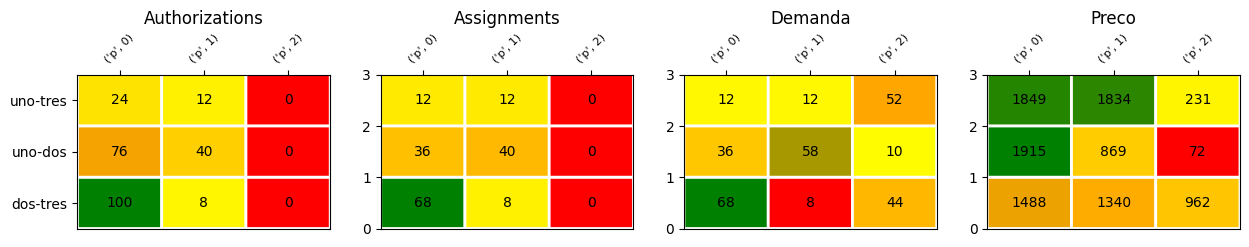

In [9]:
# grafica(a,attrs, 2, 15, 4)
grafica(a,attrs, 2, 15, 4, 1)
# grafica(a,attrs, 5, 15, 4, 0)